# IMDB Sentiment analysis

*This tutorial is based on [An Introduction to Keras Preprocessing Layers](https://blog.tensorflow.org/2021/11/an-introduction-to-keras-preprocessing.html) by Matthew Watson, [Text classification with TensorFlow Hub: Movie reviews](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) and [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) by TensorFlow.*
 
- Goal: build a binary sentiment classification model with keras preprocessing
- We use TensorBoard to view model results
- Data: imdb movie review dataset. 

## Prerequisites

To start this tutorial, you need the following setup:



- Install [TensorFlow](https://kirenz.github.io/codelabs/codelabs/tfx-install/#0) (we use TensorFlow Extended to install TensorfFlow)

## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import losses
from keras.models import load_model

import matplotlib.pyplot as plt
import datetime

print("Version: ", tf.__version__)

Version:  2.7.1


In [3]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Data

- We use the IMDB dataset with 50,000 polar movie reviews (positive or negative)
- Training data and test data: each 25,000 
- Training and testing sets are balanced (they contain an equal number of positive and negative reviews)
- The input data consists of sentences (strings)
- The labels to predict are either 0 or 1.

### Data import

- We use 3 data splits: training, validation and test data
- Split the data into 60% training and 40% test
- Split training into 60% training and 40% validation
- Resulting data split:
  - 15,000 examples for training
  - 10,000 examples for validation
  - 25,000 examples for testing

In [4]:
train_ds, val_ds, test_ds = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

2022-04-08 08:39:47.248656: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Explore data

- Each example is a sentence representing the movie review and a corresponding label. 
- The sentence is not preprocessed in any way. 
- The label is an integer value of either 0 or 1
  - 0 is a negative review
  - 1 is a positive review.
- Let's print first 2 examples.

In [5]:
for x, y in train_ds.take(2): 
    print("Input:", x) 
    print(50*".")     
    print("Target:", y) 
    print(50*"-")  

Input: tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
..................................................
Target: tf.Tensor(0, shape=(), dtype=int64)
--------------------------------------------------
Input: tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a comb

2022-04-08 08:41:40.355812: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Data preprocessing

- First, we need to decide how to represent the text data

#### TextVectorization

- We will be working with raw text (natural language inputs)
- So we will use the [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer.
- It transforms a batch of strings (one example = one string) into either a
  - list of token indices (one example = 1D tensor of integer token indices) or 
  - dense representation (one example = 1D tensor of float values representing data about the example's tokens). 

- [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) steps:

1. Standardize each example (usually lowercasing + punctuation stripping)
1. Split each example into substrings (usually words)
1. Recombine substrings into tokens (usually ngrams)
1. Index tokens (associate a unique int value with each token)
1. Transform each example using this index, either into a vector of ints or a dense float vector.

#### Multi-hot encoding

- Multi-hot encoding: only consider the presence or absence of terms in the review.

- For example: 
    - layer vocabulary is ['movie', 'good', 'bad']
    - a review read 'This movie was bad.'
    - We would encode this as [1, 0, 1]
    - where movie (the first vocab term) and bad (the last vocab term) are present.

1. Create a `TextVectorization` layer with multi-hot output and a max of 2500 tokens
1. Map over our training dataset and discard the integer label indicating a positive or negative review (this gives us a dataset containing only the review text) 
1. `adapt()` the layer over this dataset, which causes the layer to learn a vocabulary of the most frequent terms in all documents, capped at a max of 2500.

- `Adapt` is a utility function on all stateful preprocessing layers, which allows layers to set their internal state from input data. 

- Calling adapt is always optional. 
- For TextVectorization, we could instead supply a precomputed vocabulary on layer construction, and skip the adapt step.

In [6]:
text_vectorizer = layers.TextVectorization(
     output_mode='multi_hot', 
     max_tokens=2500
     )

features = train_ds.map(lambda x, y: x)

text_vectorizer.adapt(features)

- Next, we define a preprocessing function
- This is especially useful if you combine multiple preprocessing steps
- Here, we only use one step: `preprocess` converts raw input data to the representation we want for our model

In [7]:
def preprocess(x):
  return text_vectorizer(x)

## Model

### Architecture

In [8]:
inputs = keras.Input(shape=(1,), dtype='string')

outputs = layers.Dense(1)(preprocess(inputs))

model = keras.Model(inputs, outputs)

### Compile

In [9]:
model.compile(
    optimizer='adam',
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
    )

- Show model summary

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 2500)             0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 1)                 2501      
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


- Let’s visualize the topology of the model

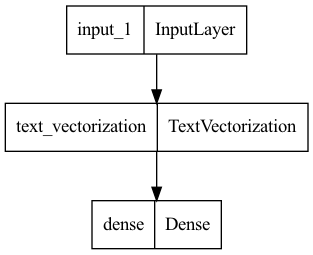

In [11]:
keras.utils.plot_model(model, "sentiment_classifier.png")

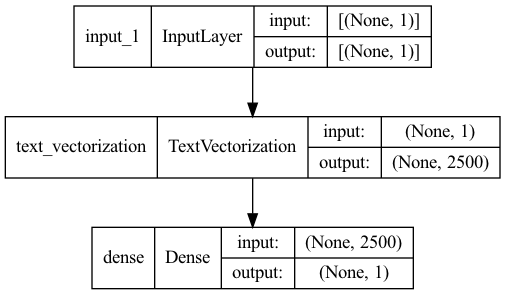

In [12]:
keras.utils.plot_model(model, "sentiment_classifier_with_shape_info.png", show_shapes=True)

### Training

- We can now train a simple model on top of this multi-hot encoding. 

First, we set up TensorBoard and an early stopping rule:

1. Define the directory where TensorBoard stores log files (we create folders with timestamps by using [`datetime`](https://docs.python.org/3/library/datetime.html)) 
1. We add `keras.callbacks.TensorBoard` callback which ensures that logs are created and stored.
1. To prevent overfitting, we use a callback wich will stop the training when there is no improvement in the validation accuracy for three consecutive epochs.


In [13]:
# Create TensorBoard folders
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create callbacks
my_callbacks = [
    keras.callbacks.TensorBoard(log_dir=log_dir),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
]

Model training:

- Train the model for 10 epochs in mini-batches of 512 samples
- We shuffle the data and use a `buffer_size` of 10000
- We monitor the model's loss and accuracy on the 10,000 samples from the validation set.


*`buffer_size` is the number of items in the shuffle buffer. The function fills the buffer and then randomly samples from it. A big enough buffer is needed for proper shuffling, but it's a balance with memory consumption. Reshuffling happens automatically at every epoch*

In [14]:
epochs = 10

history = model.fit(
    train_ds.shuffle(buffer_size=10000).batch(512),
    epochs=epochs,
    validation_data=val_ds.batch(512),
    callbacks=my_callbacks,
    verbose=1)

Epoch 1/10
30/30 [==============================] - 2s 43ms/step - loss: 0.6478 - accuracy: 0.5346 - val_loss: 0.6004 - val_accuracy: 0.5917
Epoch 2/10
30/30 [==============================] - 1s 34ms/step - loss: 0.5634 - accuracy: 0.6402 - val_loss: 0.5378 - val_accuracy: 0.6685
Epoch 3/10
30/30 [==============================] - 1s 33ms/step - loss: 0.5088 - accuracy: 0.7152 - val_loss: 0.4969 - val_accuracy: 0.7467
Epoch 4/10
30/30 [==============================] - 1s 35ms/step - loss: 0.4698 - accuracy: 0.7618 - val_loss: 0.4654 - val_accuracy: 0.7643
Epoch 5/10
30/30 [==============================] - 1s 33ms/step - loss: 0.4403 - accuracy: 0.7949 - val_loss: 0.4420 - val_accuracy: 0.7846
Epoch 6/10
30/30 [==============================] - 1s 32ms/step - loss: 0.4169 - accuracy: 0.8119 - val_loss: 0.4238 - val_accuracy: 0.8059
Epoch 7/10
30/30 [==============================] - 1s 32ms/step - loss: 0.3977 - accuracy: 0.8286 - val_loss: 0.4087 - val_accuracy: 0.8098
Epoch 8/10
30

Show number of epochs:

In [15]:
len(history.history['loss']) 

10

## Evaluation

### Loss and accuracy

- Show loss and accuracy for test data

In [16]:
results = model.evaluate(test_ds.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 1s - loss: 0.3825 - accuracy: 0.8219 - 1s/epoch - 24ms/step
loss: 0.383
accuracy: 0.822


- Create a plot of accuracy and loss over time
- `model.fit()` returns a history object that contains a dictionary with everything that happened during training.

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

- There are four entries: one for each monitored metric during training and validation. 
- You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

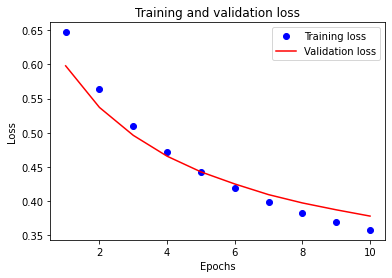

In [18]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# r is for "solid red line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

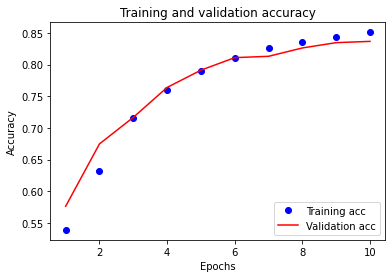

In [19]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

- Blue dots represent the training loss and accuracy
- Solid red lines are the validation loss and accuracy.

- Training loss decreases with each epoch 
- Training accuracy increases with each epoch. 
- This is expected when using a gradient descent optimization
- It should minimize the desired quantity on every iteration.

### TensorBoard

- How to use TensorBoard in Visual Studio Code ([Stackoverflow](https://stackoverflow.com/a/66375514)):

1. Open the command palette (Ctrl/Cmd + Shift + P)
2. Search for the command “Python: Launch TensorBoard” and press enter.
3. Select the folder where your TensorBoard log files are located:
   - Select folder `logs/fit` 

Alternatively, you can use TensorBoard directely in Jupyter Notebook: 

In [20]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 57180), started 0:45:14 ago. (Use '!kill 57180' to kill it.)

## Inference on new data

- Create new example data

In [21]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

- Add a sigmoid activation layer to our model to obtain probabilities

In [22]:
probability_model = keras.Sequential([
                        model, 
                        layers.Activation('sigmoid')
                        ])

In [23]:
probability_model.predict(examples)

array([[0.51533335],
       [0.43800226],
       [0.42223874]], dtype=float32)

## Save model

A Keras model consists of multiple components:

1. The architecture, or configuration, which specifies what layers the model contain, and how they're connected.
1. A set of weights values (the "state of the model").
1. An optimizer (defined by compiling the model).
1. A set of losses and metrics (defined by compiling the model or calling add_loss() or 
add_metric()).


The [Keras model saving API](https://keras.io/api/models/model_saving_apis/) makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:

- Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice.
- Saving the architecture / configuration only, typically as a JSON file.
- Saving the weights values only. This is generally used when training the model.

- We will save the complete model as Tensorflow SavedModel

In [24]:
model.save('imdb_model')

2022-04-07 22:15:29.907350: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: imdb_model/assets


INFO:tensorflow:Assets written to: imdb_model/assets


## Load model

In [25]:
model_new = load_model('imdb_model')

In [26]:
model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 2500)             0         
 torization)                                                     
                                                                 
 dense (Dense)               (None, 1)                 2501      
                                                                 
Total params: 2,501
Trainable params: 2,501
Non-trainable params: 0
_________________________________________________________________


## Feature engineering example

- The following code is an add on to demonstrate how to perform further feature engineering

- Let’s experiment with a new feature 
- Our multi-hot encoding does not contain any notion of review length
- We can try adding a feature for normalized string length. 

- Preprocessing layers can be mixed with TensorFlow ops and custom layers as desired. 
- Here we can combine the `tf.strings.length` function with the `Normalization` layer, which will scale the input to have 0 mean and 1 variance. 
- We have only updated code up to the preprocess function below, but we will show the rest of training for clarity.

In [27]:
# This layer will scale our review length feature to mean 0 variance 1.
normalizer = layers.Normalization(axis=None)
normalizer.adapt(features.map(lambda x: tf.strings.length(x)))

def preprocess(x):
  multi_hot_terms = text_vectorizer(x)
  normalized_length = normalizer(tf.strings.length(x))
  # Combine the multi-hot encoding with review length.
  return layers.concatenate((multi_hot_terms, normalized_length))

In [28]:
inputs = tf.keras.Input(shape=(1,), dtype='string')
outputs = layers.Dense(1)(preprocess(inputs))
model = tf.keras.Model(inputs, outputs)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

epochs = 5
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_ds.shuffle(buffer_size=10000).batch(512),
    epochs=epochs,
    validation_data=val_ds.batch(512),
    callbacks=[callback],
    verbose=1)

Epoch 1/5
30/30 [==============================] - 3s 70ms/step - loss: 0.6334 - val_loss: 0.5882
Epoch 2/5
30/30 [==============================] - 3s 96ms/step - loss: 0.5514 - val_loss: 0.5281
Epoch 3/5
30/30 [==============================] - 3s 104ms/step - loss: 0.4983 - val_loss: 0.4869
Epoch 4/5
30/30 [==============================] - 3s 92ms/step - loss: 0.4586 - val_loss: 0.4544
Epoch 5/5
30/30 [==============================] - 2s 78ms/step - loss: 0.4273 - val_loss: 0.4288


- Above, we create the normalization layer and adapt it to our input. 
- Within the preprocess function, we simply concatenate our multi-hot encoding and length features together. 
- We learn a model over the union of the two feature representations.